Extracting metadata from images: 100%|██████████| 526/526 [00:02<00:00, 226.66it/s]


Total images processed: 522
Images with valid metadata: 464
Images lacking valid metadata: 58


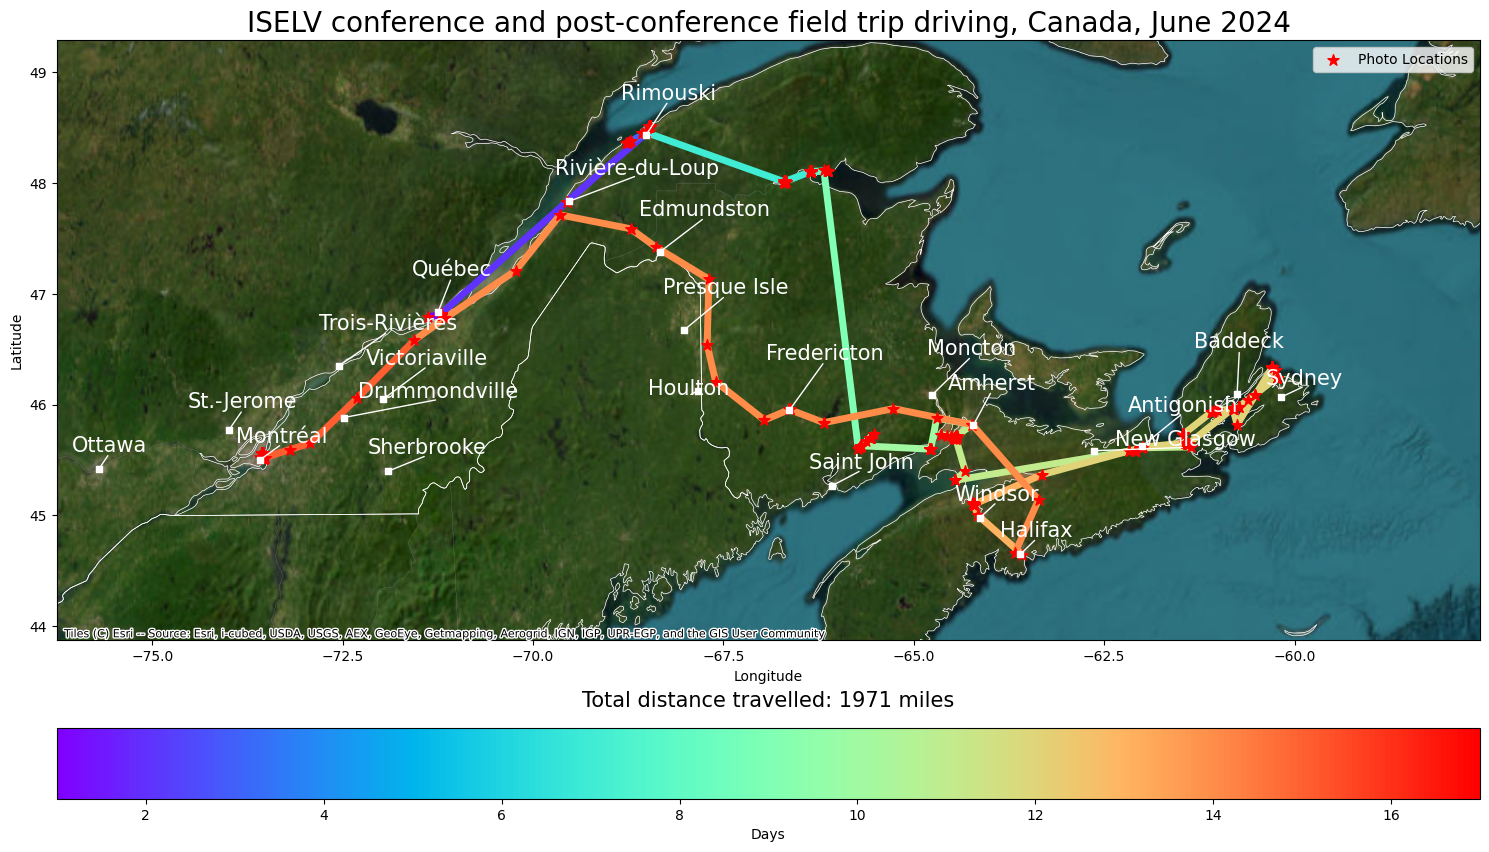

Total path length: 1971.46 miles


In [92]:
import os
import pandas as pd
import numpy as np
import exifread
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime
from shapely.geometry import box
from adjustText import adjust_text
from tqdm import tqdm 

##### User inputs #####
# Directory containing your images
image_dir = '/Users/Jake/testphotos/lowres'
# Directory containing the map/city data
cultural_dir = '/Users/Jake/testphotos/110m_cultural'

projection = 'EPSG:4326'        # Set map projection
margin = 0.2                    # Set margin proportion around plotted path
figsize = (15, 10)              # Set figure dimensions
units = 'miles'                 # Set units (miles or km)

plot_title = 'ISELV conference and post-conference field trip driving, Canada, June 2024'
titlefontsize = 20              # Set plot title font size

pathcolor = 'rainbow'           # Set colour of path, either colormap or solid color
use_gradient_color = True       # Set to True for gradient colormap, False for solid color
pathwidth = 5                   # Set width of path

photocolor = "red"              # Set color of photo markers
photoshape = "*"                # Set shape of photo markers
photosize = 70                  # Set size of photo markers

citycolor = 'white'             # Set color of city makers
cityshape = "s"                 # Set shape of city markers
citysize = 20                   # Set size of city markers
numtopcities = 5                # Set number of top cities (by population) to display in area
citydistance = 30               # Set distance from the path (in miles/km) to nearby cities to display
citylabelcolor = 'white'        # Set color of the city labels
cityfontsize = 15               # Set size of city labels
cityarrowcolor = 'white'        # Set color of arrows to city labels
cityarrowstyle = '-'            # Set style of arrows to city labels
cityarrowwidth = 1              # Set width of arrows to city labels

countrybordercolor = 'white'    # Set color of country borders
countryborderwidth = 0.5        # Set width of country borders
statebordercolor = 'gray'       # Set color of state borders
stateborderwidth = 0.1          # Set width of state borders


# Function to extract GPS coordinates from EXIF data
def get_gps_data(tags):
    if 'GPS GPSLatitude' in tags and 'GPS GPSLongitude' in tags:
        lat_ref = tags['GPS GPSLatitudeRef'].printable
        lat = [float(x.num) / float(x.den) for x in tags['GPS GPSLatitude'].values]
        lon_ref = tags['GPS GPSLongitudeRef'].printable
        lon = [float(x.num) / float(x.den) for x in tags['GPS GPSLongitude'].values]
        lat = lat[0] + lat[1] / 60 + lat[2] / 3600
        lon = lon[0] + lon[1] / 60 + lon[2] / 3600
        if lat_ref != "N":
            lat = -lat
        if lon_ref != "E":
            lon = -lon
        return lat, lon
    return None

# Function to extract time and GPS data from an image
def extract_image_metadata(image_path):
    with open(image_path, 'rb') as f:
        tags = exifread.process_file(f)
    gps_data = get_gps_data(tags)
    date_taken = tags.get('EXIF DateTimeOriginal', None)
    if date_taken:
        date_taken = datetime.strptime(str(date_taken), '%Y:%m:%d %H:%M:%S')
    return gps_data, date_taken

# Function to calculate the distance between two points using the Haversine formula
def haversine(coord1, coord2):
    R = 6371000  # Radius of the Earth in meters
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    if units == 'miles':
        return R * c / 1609.34  # Convert meters to miles
    elif units == 'km':
        return R * c / 1000  # Convert meters to km

# Extract metadata from all images
image_metadata = []
valid_metadata_count = 0
invalid_metadata_count = 0
for image_name in tqdm(os.listdir(image_dir), desc="Extracting metadata from images"):
    if image_name.lower().endswith(('jpg', 'jpeg', 'png')):
        image_path = os.path.join(image_dir, image_name)
        gps_data, date_taken = extract_image_metadata(image_path)
        if gps_data and date_taken:
            image_metadata.append((gps_data, date_taken))
            valid_metadata_count += 1
        else:
            invalid_metadata_count += 1
print(f"Total images processed: {valid_metadata_count + invalid_metadata_count}")
print(f"Images with valid metadata: {valid_metadata_count}")
print(f"Images lacking valid metadata: {invalid_metadata_count}")

# Check if we have any valid metadata
if not image_metadata:
    print("ERROR: No images with valid GPS and date metadata found.")
    exit()
else:
    # Sort metadata by date
    image_metadata.sort(key=lambda x: x[1])

    # Extract latitudes, longitudes, and dates
    lats, lons = zip(*[data[0] for data in image_metadata])
    dates = [data[1] for data in image_metadata]

    # Map unique dates to colors
    unique_dates = list(sorted(set(d.date() for d in dates)))
    date_to_color = {date: i for i, date in enumerate(unique_dates)}

    # Calculate total path length
    total_distance = sum(haversine((lats[i], lons[i]), (lats[i+1], lons[i+1])) for i in range(len(lats) - 1))

    # Create a GeoDataFrame for photos
    gdf = gpd.GeoDataFrame(
        {'geometry': gpd.points_from_xy(lons, lats)},
        crs=projection
    )
    #print(gdf)

    # Create a LineCollection for the path with colors based on dates
    segments = []
    colors = []
    if use_gradient_color:
        norm = mcolors.Normalize(vmin=1, vmax=len(unique_dates))  # Adjusted to start from 1
        cmap = plt.get_cmap(pathcolor)
        for i in range(len(lats) - 1):
            segment = [(lons[i], lats[i]), (lons[i+1], lats[i+1])]
            segments.append(segment)
            colors.append(date_to_color[dates[i].date()])
    
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(np.array(colors))
    else:
        for i in range(len(lats) - 1):
            segment = [(lons[i], lats[i]), (lons[i+1], lats[i+1])]
            segments.append(segment)
        lc = LineCollection(segments, colors=pathcolor, linewidth=pathwidth)
    lc.set_linewidth(pathwidth)
    fig, ax = plt.subplots(figsize=figsize)

    # Annotate major cities
    cities_shp = os.path.join(cultural_dir, 'ne_10m_populated_places.dbf')
    if os.path.exists(cities_shp):
        cities = gpd.read_file(cities_shp, encoding='utf-8')
        # Set the initial CRS if not already set (assuming it's EPSG:4326)
        if cities.crs is None:
            cities = cities.set_crs('EPSG:4326')
        cities = cities.to_crs(projection)  # Reproject cities to match the projection

        # Filter cities within the bounding box of the photo locations
        bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
        minx, miny, maxx, maxy = bounds

        # Add a buffer to the bounding box
        buffer_ratio = margin  # margin around plotted points
        x_buffer = (maxx - minx) * buffer_ratio
        y_buffer = (maxy - miny) * buffer_ratio
        minx -= x_buffer
        maxx += x_buffer
        miny -= y_buffer
        maxy += y_buffer

        # Set the limits of the map to the expanded bounding box
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=projection)

        # Add state borders
        states = gpd.read_file(os.path.join(cultural_dir, 'ne_10m_admin_1_states_provinces.shp'))
        states = states.set_crs('EPSG:4326')  # Set the initial CRS to EPSG:4326 (assuming it is the correct one)
        states = states.to_crs(projection)  # Reproject states to match the desired projection
        states.boundary.plot(ax=ax, edgecolor=statebordercolor, linewidth=stateborderwidth)

        # Add country borders
        world_high_res = gpd.read_file(os.path.join(cultural_dir, 'ne_10m_admin_0_countries.shp'))
        world_high_res.boundary.plot(ax=ax, edgecolor=countrybordercolor, linewidth=countryborderwidth)

        bbox = gpd.GeoDataFrame(index=[0], crs=projection, geometry=[box(minx, miny, maxx, maxy)])
        cities_within_bounds = gpd.sjoin(cities, bbox, how='inner', predicate='intersects')

        # Sort cities by population and select the top 5
        top_x_cities = cities_within_bounds.sort_values(by='POP_MAX', ascending=False).head(numtopcities)

        # Find cities within 30km of at least one photo location
        cities_within_x_km = cities_within_bounds[
            cities_within_bounds.apply(
                lambda city: any(haversine((lat, lon), (city.geometry.y, city.geometry.x)) <= citydistance for lat, lon in zip(lats, lons)),
                axis=1
            )
        ]

        # Combine the top 5 cities and cities within 30km, ensuring no duplicates
        all_cities = pd.concat([top_x_cities, cities_within_x_km]).drop_duplicates()
        #print(all_cities.columns)
        city_name_column = u'NAME'  # Adjust column name based on your shapefile
        all_cities.plot(ax=ax, color=citycolor, marker=cityshape, markersize=citysize, zorder=5)
    
        # Collect text annotations
        texts = []
        x_coords = []  # Use different names to avoid confusion
        y_coords = []  # Use different names to avoid confusion

        # Iterate over all cities to create text annotations
        for x_iter, y_iter, label in zip(all_cities.geometry.x, all_cities.geometry.y, all_cities[city_name_column]):
            texts.append(ax.text(x_iter, y_iter, label, fontsize=cityfontsize, color=citylabelcolor, zorder=4))
            x_coords.append(x_iter)  # Append to x_coords list
            y_coords.append(y_iter)  # Append to y_coords list
    
        # Adjust text positions to minimize overlap
        adjust_text(texts, precision=1, expand_text=(1.001, 1.001)) #arrowprops=dict(arrowstyle=cityarrowstyle, color=cityarrowcolor, lw=cityarrowwidth)
       
        # Manually adjust positions to be on top of points and draw arrows
        for i, text in enumerate(texts):
            # Example adjustment to move labels above points
            x_pos, y_pos = text.get_position()
            x_pos = x_pos - 0.5
            y_pos = y_pos + 0.2
            text.set_position((x_pos, y_pos))  # Adjust y-position to be above the points

            # Ensure x_coords and y_coords are lists and index within their bounds
            if isinstance(x_coords, list) and isinstance(y_coords, list):
                if 0 <= i < len(x_coords) and 0 <= i < len(y_coords):
                    # Update arrows (FancyArrowPatch)
                    arrow = FancyArrowPatch((x_coords[i], y_coords[i]), (x_pos, y_pos-0.07), 
                                            arrowstyle='-', color='white', mutation_scale=50, 
                                            zorder=6)
                    ax.add_patch(arrow)
                else:
                    print(f"Index out of bounds for coordinates at index {i}.")
            else:
                print("Bounds error: x_coords or y_coords are not lists or tuples.")

    else:
        print("City shapefile is missing. Skipping city annotations.")

    # Plot the data
    gdf.plot(ax=ax, marker=photoshape, color=photocolor, markersize=photosize, label='Photo Locations', zorder=3)
    ax.add_collection(lc)

    # Add colorbar for the days
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.arange(1, len(unique_dates) + 1))  # Adjusted to start from 1
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.09)
    cbar.set_label('Days')

    # Set axis labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add text annotation for total path length
    ax.text(0.5, -0.1, f"Total distance travelled: {total_distance:.0f} {units}", ha='center', va='center', transform=ax.transAxes, fontsize=15)

    plt.legend()
    plt.title(plot_title, fontsize=titlefontsize)
    plt.tight_layout()
    plt.show()

    print(f"Total path length: {total_distance:.2f} {units}")


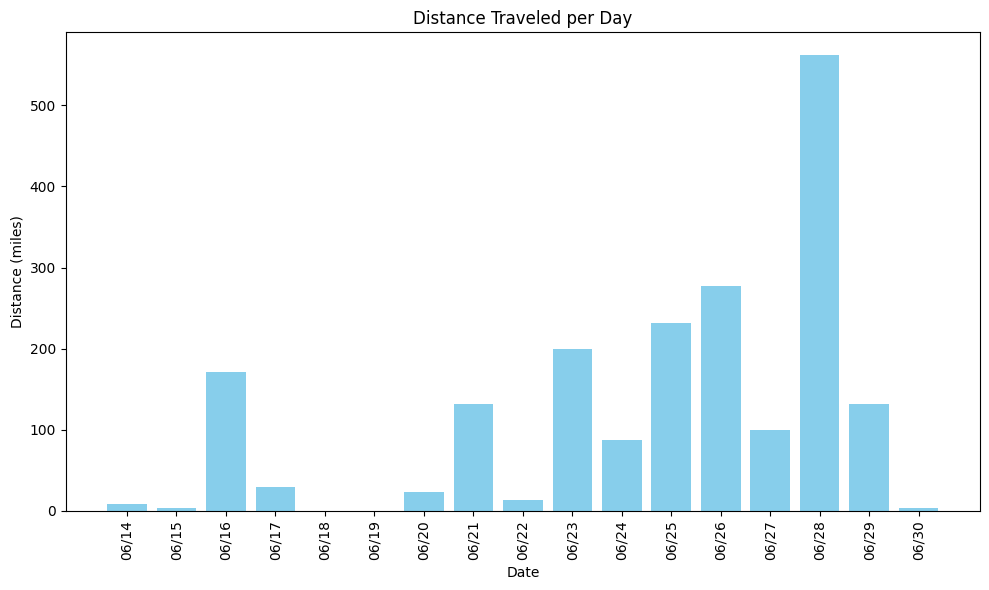

In [90]:
# Calculate distance traveled per day
daily_distances = []
current_day = dates[0].date()
current_distance = 0.0
for i in range(len(lats) - 1):
    if dates[i].date() == current_day:
        current_distance += haversine((lats[i], lons[i]), (lats[i+1], lons[i+1]))
    else:
        daily_distances.append((current_day.strftime('%m/%d'), current_distance))
        current_day = dates[i].date()
        current_distance = haversine((lats[i], lons[i]), (lats[i+1], lons[i+1]))
# Add the last day's distance
daily_distances.append((current_day.strftime('%m/%d'), current_distance))
# Convert daily distances to DataFrame for easier plotting
df_daily_distances = pd.DataFrame(daily_distances, columns=['Date', 'Distance'])
# Plot daily distances
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.bar(df_daily_distances['Date'], df_daily_distances['Distance'], color='skyblue')
ax2.set_xlabel('Date')
ax2.set_ylabel(f'Distance ({units})')
ax2.set_title('Distance Traveled per Day')
ax2.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()